In [ ]:
%load_ext tensorboard

In [ ]:
from google.colab import files
from sklearn.utils import class_weight
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.preprocessing import image
from keras.layers import Flatten, Dense, GlobalAveragePooling2D, Dropout
from keras.applications.resnet50 import ResNet50
from keras import Input
from keras import Model

import numpy as np
import tensorflow as tf
import os
import zipfile
import matplotlib.pyplot as plt
import random

import signal
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score

import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

import kagglehub
from glob import glob
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
import datetime
from tensorflow.keras.models import load_model



In [ ]:
# Download the dataset
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("Dataset descargado en:", path)

source_base = os.path.join(path, "chest_xray")
target_base = "/kaggle/working/chest_xray"
splits = ['train', 'val', 'test']

# Reorganize the images of PNEUMONIA in BACTERIAL and VIRAL
for split in splits:
    src_split = Path(source_base) / split
    dst_split = Path(target_base) / split
    if not dst_split.exists():
        shutil.copytree(src_split, dst_split, dirs_exist_ok=True)

    pneumonia_folder = dst_split / "PNEUMONIA"
    bacterial_folder = dst_split / "BACTERIAL"
    viral_folder = dst_split / "VIRAL"

    bacterial_folder.mkdir(exist_ok=True)
    viral_folder.mkdir(exist_ok=True)

    for file in pneumonia_folder.glob("*.jpeg"):
        fname = file.name.lower()
        if "bacteria" in fname:
            shutil.move(str(file), bacterial_folder / file.name)
        elif "virus" in fname:
            shutil.move(str(file), viral_folder / file.name)

    if pneumonia_folder.exists() and not list(pneumonia_folder.glob("*")):
        pneumonia_folder.rmdir()


Dataset descargado en: /kaggle/input/chest-xray-pneumonia


In [ ]:
# We reuse /kaggle/working/chest_xray/train, val, test
base_dir = "/kaggle/working/chest_xray"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

In [ ]:
class_names = ['NORMAL', 'BACTERIAL', 'VIRAL']
folder_directory = base_dir  # /kaggle/working/chest_xray

for folder_type in ['val', 'test']:
    folder_dir = os.path.join(folder_directory, folder_type)
    for class_name in class_names:
        source_class_dir = os.path.join(folder_dir, class_name)
        train_class_dir = os.path.join(train_dir, class_name)

        if os.path.exists(source_class_dir):
            for file in os.listdir(source_class_dir):
                file_path = os.path.join(source_class_dir, file)
                if os.path.isfile(file_path):
                    shutil.move(file_path, os.path.join(train_class_dir, file))
            print(f"Moved images from {source_class_dir} to {train_class_dir}")
        else:
            print(f"No folder found for '{class_name}' in {folder_type}")

✅ Moved images from /kaggle/working/chest_xray/val/NORMAL to /kaggle/working/chest_xray/train/NORMAL
✅ Moved images from /kaggle/working/chest_xray/val/BACTERIAL to /kaggle/working/chest_xray/train/BACTERIAL
✅ Moved images from /kaggle/working/chest_xray/val/VIRAL to /kaggle/working/chest_xray/train/VIRAL
✅ Moved images from /kaggle/working/chest_xray/test/NORMAL to /kaggle/working/chest_xray/train/NORMAL
✅ Moved images from /kaggle/working/chest_xray/test/BACTERIAL to /kaggle/working/chest_xray/train/BACTERIAL
✅ Moved images from /kaggle/working/chest_xray/test/VIRAL to /kaggle/working/chest_xray/train/VIRAL


In [ ]:
# Create the folders if they dont exist
for split in ['train', 'val', 'test']:
    for class_name in class_names:
        class_path = os.path.join(base_dir, split, class_name)
        os.makedirs(class_path, exist_ok=True)

In [ ]:
percentage_to_move = 0.15

for class_name in class_names:
    train_class_dir = os.path.join(train_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)

    image_files = [f for f in os.listdir(train_class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    num_to_move = int(len(image_files) * percentage_to_move)
    images_to_move = random.sample(image_files, num_to_move)

    for image in images_to_move:
        shutil.move(os.path.join(train_class_dir, image), os.path.join(test_class_dir, image))

    print(f"Moved {num_to_move} images to test/{class_name}")

✅ Moved 237 images to test/NORMAL
✅ Moved 417 images to test/BACTERIAL
✅ Moved 223 images to test/VIRAL


In [ ]:
percentage_to_move = 0.05

for class_name in class_names:
    train_class_dir = os.path.join(train_dir, class_name)
    val_class_dir = os.path.join(val_dir, class_name)

    image_files = [f for f in os.listdir(train_class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    num_to_move = int(len(image_files) * percentage_to_move)
    images_to_move = random.sample(image_files, num_to_move)

    for image in images_to_move:
        shutil.move(os.path.join(train_class_dir, image), os.path.join(val_class_dir, image))

    print(f"Moved {num_to_move} images to val/{class_name}")


✅ Moved 67 images to val/NORMAL
✅ Moved 118 images to val/BACTERIAL
✅ Moved 63 images to val/VIRAL


In [ ]:
for split in ['train', 'val', 'test']:
    split_dir = os.path.join(base_dir, split)
    print(f"\nClasses found in {split.upper()} set:")
    for class_name in class_names:
        class_dir = os.path.join(split_dir, class_name)
        num_images = len([
            f for f in os.listdir(class_dir)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])
        print(f"{class_name}: {num_images} images")


📂 Classes found in TRAIN set:
📁 NORMAL: 1279 images
📁 BACTERIAL: 2245 images
📁 VIRAL: 1207 images

📂 Classes found in VAL set:
📁 NORMAL: 67 images
📁 BACTERIAL: 118 images
📁 VIRAL: 63 images

📂 Classes found in TEST set:
📁 NORMAL: 237 images
📁 BACTERIAL: 417 images
📁 VIRAL: 223 images


In [ ]:
# Folders defined
train_virus_dir = os.path.join(train_dir, "VIRAL")
val_virus_dir = os.path.join(val_dir, "VIRAL")

# 1. Erase the previous images in val/VIRAL
for img in glob(os.path.join(val_virus_dir, "*.jpeg")):
    os.remove(img)

# 2. Select 8 random images from the training dataset
virus_images = glob(os.path.join(train_virus_dir, "*.jpeg"))
selected = random.sample(virus_images, 8)

# 3. Copy in validation dataset
for file in selected:
    shutil.copy(file, val_virus_dir)


In [ ]:
# Step 1: Image loading
# Step 1: Image loading (Augmentation and No Augmentation)
input_size = 224
batch_size = 32
num_colors = 3  # RGB

# With augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(input_size, input_size),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(input_size, input_size),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(input_size, input_size),
    batch_size=1,
    class_mode='categorical',
    shuffle=False,
    color_mode='rgb'
)

# Without augmentation
train_datagen_outaug = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen_outaug = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen_outaug = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator_outaug = train_datagen_outaug.flow_from_directory(
    train_dir,
    target_size=(input_size, input_size),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

val_generator_outaug = val_datagen_outaug.flow_from_directory(
    val_dir,
    target_size=(input_size, input_size),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

test_generator_outaug = test_datagen_outaug.flow_from_directory(
    test_dir,
    target_size=(input_size, input_size),
    batch_size=1,
    class_mode='categorical',
    shuffle=False,
    color_mode='rgb'
)

# Show the classes
class_names = list(train_generator.class_indices.keys())
print("Classes:", class_names)


Found 4731 images belonging to 3 classes.
Found 193 images belonging to 3 classes.
Found 877 images belonging to 3 classes.
Found 4731 images belonging to 3 classes.
Found 193 images belonging to 3 classes.
Found 877 images belonging to 3 classes.
Classes: ['BACTERIAL', 'NORMAL', 'VIRAL']


In [ ]:
def run_experiment(learning_rate, augment=True, run_name=None):
    print(f"\nTraining with LR={learning_rate}, Augment={augment}")

    # Show the generators based on augmentation
    if augment:
        train_gen = train_generator
        val_gen = val_generator
        test_gen = test_generator
    else:
        train_gen = train_generator_outaug
        val_gen = val_generator_outaug
        test_gen = test_generator_outaug

    num_classes = len(train_gen.class_indices)

    # Base Model base + Final arquitecture
    input_tensor = Input(shape=(input_size, input_size, 3))
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Callbacks
    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    run_id = run_name if run_name else f"lr{learning_rate}-aug{augment}-{timestamp}"

    log_dir = f"logs/{run_id}"
    model_path = f"models/model-{run_id}.keras"

    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    checkpoint_callback = ModelCheckpoint(
        filepath=model_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1,
        mode='min'
    )

    # Training
    history = model.fit(
        train_gen,
        steps_per_epoch=4,
        epochs=10,
        validation_data=val_gen,
        callbacks=[tensorboard_callback, checkpoint_callback]
    )

    # Evaluation
    results = model.evaluate(test_gen)
    print(f"Test Loss: {results[0]:.4f} — Accuracy: {results[1]:.4f}")

    # Predictions
    predictions = model.predict(test_gen)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_gen.classes

    label_map = {v: k for k, v in test_gen.class_indices.items()}
    target_names = [label_map[i] for i in sorted(label_map)]

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=target_names,
                yticklabels=target_names)
    plt.title(f"Confusion Matrix — {run_id}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=target_names))
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"Weighted F1 Score: {f1:.4f}")

    return {
        "learning_rate": learning_rate,
        "augment": augment,
        "loss": results[0],
        "accuracy": results[1],
        "f1": f1,
        "confusion_matrix": cm
    }



🔁 Training with LR=0.0001, Augment=True
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_537']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - accuracy: 0.4948 - loss: 1.1801
Epoch 1: val_loss improved from inf to 0.95294, saving model to models/model-lr0.0001-augTrue-20250504-170615.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 35s 6s/step - accuracy: 0.4990 - loss: 1.1751 - val_accuracy: 0.4870 - val_loss: 0.9529
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.3906 - loss: 1.2196
Epoch 2: val_loss did not improve from 0.95294
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - accuracy: 0.3969 - loss: 1.2200 - val_accuracy: 0.4819 - val_loss: 0.9759
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.4609 - loss: 1.1312 
Epoch 3: val_loss improved from 0.95294 to 0.76220, saving model to models/model-lr0.0001-augTrue-20250504-170615.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.4688 - loss: 1.1234 - val_accuracy: 0.6995 - val_loss: 0.7622
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.5254 - loss: 1.0965
Epoch 4: val_loss improved from 0.76220 to 0.66518, s

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_537']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


877/877 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step


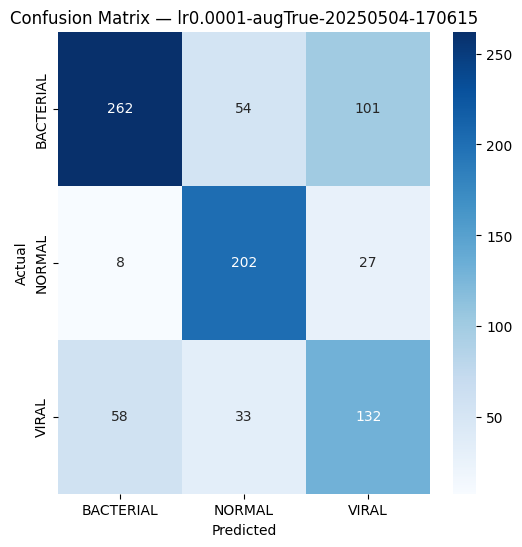


📄 Classification Report:
              precision    recall  f1-score   support

   BACTERIAL       0.80      0.63      0.70       417
      NORMAL       0.70      0.85      0.77       237
       VIRAL       0.51      0.59      0.55       223

    accuracy                           0.68       877
   macro avg       0.67      0.69      0.67       877
weighted avg       0.70      0.68      0.68       877

🎯 Weighted F1 Score: 0.6810

🔁 Training with LR=0.0001, Augment=False


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_716']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.2324 - loss: 1.7563
Epoch 1: val_loss improved from inf to 1.09433, saving model to models/model-lr0.0001-augFalse-20250504-170932.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 29s 6s/step - accuracy: 0.2406 - loss: 1.7120 - val_accuracy: 0.3472 - val_loss: 1.0943
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.4023 - loss: 1.5326
Epoch 2: val_loss improved from 1.09433 to 0.85714, saving model to models/model-lr0.0001-augFalse-20250504-170932.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - accuracy: 0.4031 - loss: 1.5319 - val_accuracy: 0.5699 - val_loss: 0.8571
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.4889 - loss: 1.2552
Epoch 3: val_loss improved from 0.85714 to 0.73614, saving model to models/model-lr0.0001-augFalse-20250504-170932.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.4771 - loss: 1.2882 - val_accuracy: 0.6477 - val_loss: 0.7361
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_716']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


877/877 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step


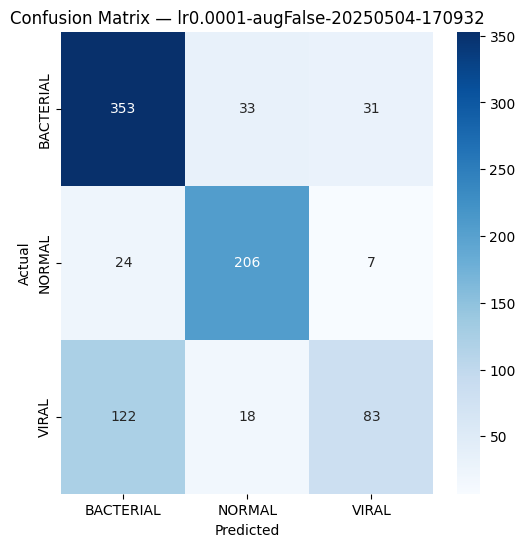


📄 Classification Report:
              precision    recall  f1-score   support

   BACTERIAL       0.71      0.85      0.77       417
      NORMAL       0.80      0.87      0.83       237
       VIRAL       0.69      0.37      0.48       223

    accuracy                           0.73       877
   macro avg       0.73      0.70      0.70       877
weighted avg       0.73      0.73      0.71       877

🎯 Weighted F1 Score: 0.7146

🔁 Training with LR=0.0005, Augment=True
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_895']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - accuracy: 0.3040 - loss: 1.7870
Epoch 1: val_loss improved from inf to 1.04293, saving model to models/model-lr0.0005-augTrue-20250504-171219.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 31s 6s/step - accuracy: 0.3198 - loss: 1.7402 - val_accuracy: 0.5907 - val_loss: 1.0429
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.5579 - loss: 1.2278
Epoch 2: val_loss improved from 1.04293 to 0.67214, saving model to models/model-lr0.0005-augTrue-20250504-171219.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - accuracy: 0.5667 - loss: 1.2031 - val_accuracy: 0.7358 - val_loss: 0.6721
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.5091 - loss: 1.0527 
Epoch 3: val_loss did not improve from 0.67214
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.5167 - loss: 1.0414 - val_accuracy: 0.6632 - val_loss: 0.7209
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.6061 - loss: 0.7863
Epoch 4: val_loss improved from 0.67214 to 0.54203, s

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_895']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


877/877 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step


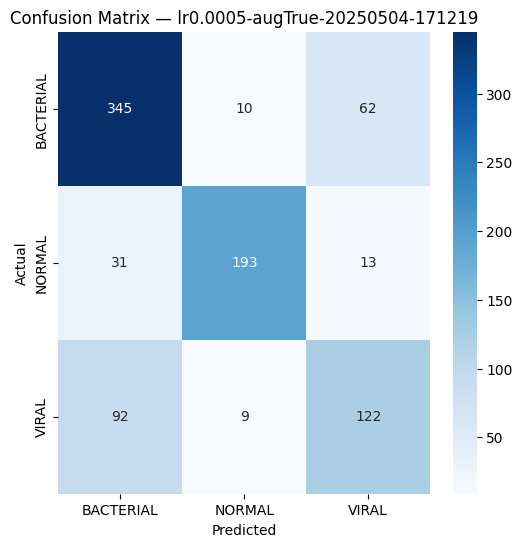


📄 Classification Report:
              precision    recall  f1-score   support

   BACTERIAL       0.74      0.83      0.78       417
      NORMAL       0.91      0.81      0.86       237
       VIRAL       0.62      0.55      0.58       223

    accuracy                           0.75       877
   macro avg       0.76      0.73      0.74       877
weighted avg       0.75      0.75      0.75       877

🎯 Weighted F1 Score: 0.7508

🔁 Training with LR=0.0005, Augment=False
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1074']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.3633 - loss: 1.7942
Epoch 1: val_loss improved from inf to 0.59261, saving model to models/model-lr0.0005-augFalse-20250504-171521.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 28s 6s/step - accuracy: 0.3812 - loss: 1.7491 - val_accuracy: 0.7720 - val_loss: 0.5926
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.6673 - loss: 0.8198
Epoch 2: val_loss improved from 0.59261 to 0.57560, saving model to models/model-lr0.0005-augFalse-20250504-171521.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.6698 - loss: 0.8208 - val_accuracy: 0.7720 - val_loss: 0.5756
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.6257 - loss: 0.8767
Epoch 3: val_loss improved from 0.57560 to 0.34346, saving model to models/model-lr0.0005-augFalse-20250504-171521.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.6333 - loss: 0.8591 - val_accuracy: 0.8653 - val_loss: 0.3435
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1074']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


877/877 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step


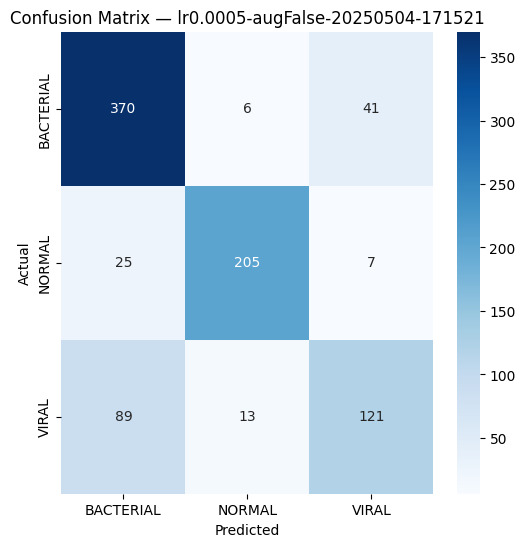


📄 Classification Report:
              precision    recall  f1-score   support

   BACTERIAL       0.76      0.89      0.82       417
      NORMAL       0.92      0.86      0.89       237
       VIRAL       0.72      0.54      0.62       223

    accuracy                           0.79       877
   macro avg       0.80      0.76      0.78       877
weighted avg       0.79      0.79      0.79       877

🎯 Weighted F1 Score: 0.7878

🔁 Training with LR=0.001, Augment=True
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1253']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.3307 - loss: 2.3139
Epoch 1: val_loss improved from inf to 2.67380, saving model to models/model-lr0.001-augTrue-20250504-171800.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 30s 6s/step - accuracy: 0.3427 - loss: 2.3683 - val_accuracy: 0.5181 - val_loss: 2.6738
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.5456 - loss: 1.7614
Epoch 2: val_loss improved from 2.67380 to 0.76822, saving model to models/model-lr0.001-augTrue-20250504-171800.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - accuracy: 0.5615 - loss: 1.6655 - val_accuracy: 0.6062 - val_loss: 0.7682
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5612 - loss: 1.3166
Epoch 3: val_loss improved from 0.76822 to 0.49343, saving model to models/model-lr0.001-augTrue-20250504-171800.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - accuracy: 0.5612 - loss: 1.3053 - val_accuracy: 0.8290 - val_loss: 0.4934
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.6947 -

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1253']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


877/877 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step


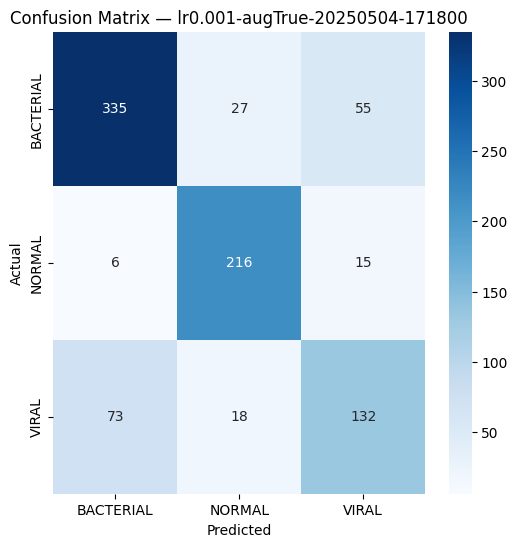


📄 Classification Report:
              precision    recall  f1-score   support

   BACTERIAL       0.81      0.80      0.81       417
      NORMAL       0.83      0.91      0.87       237
       VIRAL       0.65      0.59      0.62       223

    accuracy                           0.78       877
   macro avg       0.76      0.77      0.76       877
weighted avg       0.77      0.78      0.78       877

🎯 Weighted F1 Score: 0.7757

🔁 Training with LR=0.001, Augment=False
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1432']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.4095 - loss: 1.6830
Epoch 1: val_loss improved from inf to 0.99047, saving model to models/model-lr0.001-augFalse-20250504-172109.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 29s 6s/step - accuracy: 0.4104 - loss: 1.6513 - val_accuracy: 0.5389 - val_loss: 0.9905
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.4193 - loss: 1.3386
Epoch 2: val_loss improved from 0.99047 to 0.93764, saving model to models/model-lr0.001-augFalse-20250504-172109.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.4292 - loss: 1.2953 - val_accuracy: 0.5596 - val_loss: 0.9376
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.5729 - loss: 1.1285
Epoch 3: val_loss improved from 0.93764 to 0.33535, saving model to models/model-lr0.001-augFalse-20250504-172109.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.5771 - loss: 1.1199 - val_accuracy: 0.8808 - val_loss: 0.3354
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1432']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


877/877 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step


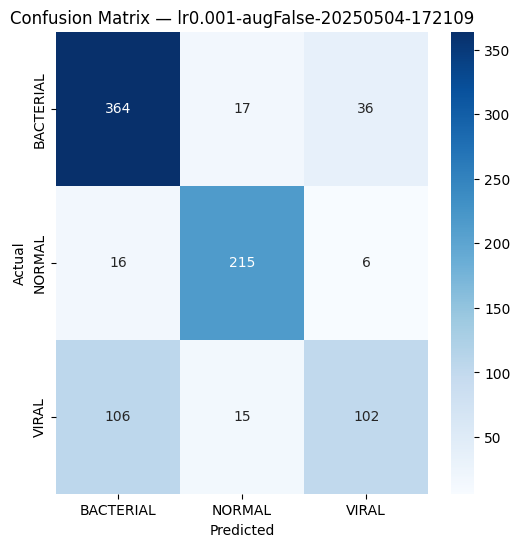


📄 Classification Report:
              precision    recall  f1-score   support

   BACTERIAL       0.75      0.87      0.81       417
      NORMAL       0.87      0.91      0.89       237
       VIRAL       0.71      0.46      0.56       223

    accuracy                           0.78       877
   macro avg       0.78      0.75      0.75       877
weighted avg       0.77      0.78      0.76       877

🎯 Weighted F1 Score: 0.7648


In [ ]:
learning_rates = [0.0001, 0.0005, 0.001]

results = []

for lr in learning_rates:
    result_aug = run_experiment(lr, augment=True)
    result_noaug = run_experiment(lr, augment=False)
    results.append((lr, result_aug, result_noaug))


In [ ]:
def show_top_predictions(model, test_gen, label_map, num_samples=3):
    class_names = [label_map[j] for j in range(len(label_map))]

    for i in range(num_samples):
        img, label = test_gen[i]
        pred = model.predict(img)
        pred_labels = np.argsort(pred[0])[::-1][:3]
        top_preds = [(class_names[j], round(pred[0][j], 2)) for j in pred_labels]

        # Show image (conversion if neccessary)
        img_to_show = img[0]
        if img_to_show.shape[-1] == 1:  # grayscale
            img_to_show = img_to_show.squeeze()
            plt.imshow(img_to_show, cmap='gray')
        else:
            plt.imshow((img_to_show * 255).astype('uint8'))

        plt.title(f"Top Predictions: {top_preds}")
        plt.axis('off')
        plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


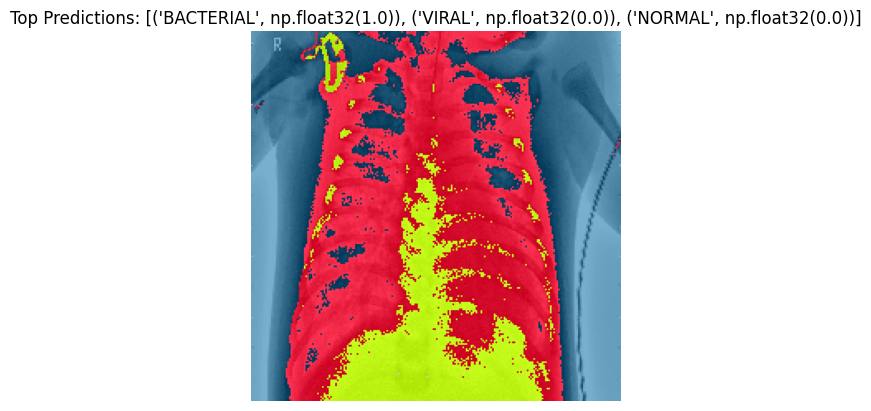

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


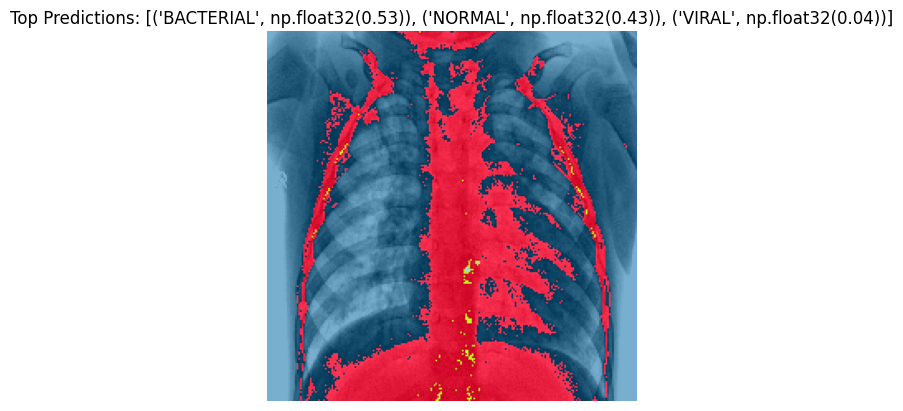

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


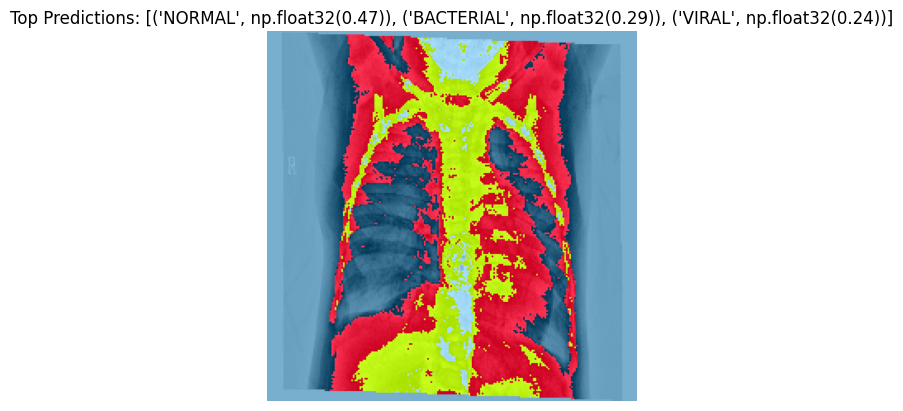

In [ ]:
# Path to the best model identified
best_model_path = "models/model-lr0.0005-augFalse-20250504-171521.keras"
model = load_model(best_model_path)

# Display the top predictions of the model
label_map = {v: k for k, v in test_generator_outaug.class_indices.items()}
show_top_predictions(model, test_generator_outaug, label_map)